# 9.6 글자 단위 RNN(Char RNN)
지금까지 배운 RNN은 전부 입력과 출력의 단위가 단어 벡터였습니다. 하지만 입출력의 단위를 단어 레벨(word-level)에서 글자 레벨(character-level)로 변경하여 RNN을 구현할 수 있습니다. 어려운 내용이 아니라 입, 출력의 단위를 단어에서 글자로 바꿨을 뿐입니다.

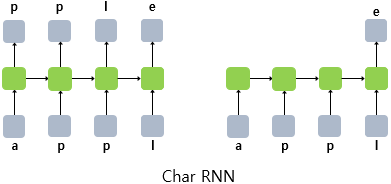

### 1. 글자 단위 RNN 언어 모델(Char RNNLM)
이전 시점의 예측 글자를 다음 시점의 입력으로 사용하는 글자 단위 RNN 언어 모델을 구현해봅시다. 앞서 배운 단어 단위 RNN 언어 모델과 다른 점은 단어 단위가 아니라 글자 단위를 입, 출력으로 사용하므로 임베딩층(embedding layer)을 여기서는 사용하지 않겠습니다. 여기서는 언어 모델의 훈련 과정과 테스트 과정의 차이를 이해하는데 초점을 둡니다.

다운로드 링크 : http://www.gutenberg.org/files/11/11-0.txt

고전 소설들은 저작권에 보호받지 않으므로, 무료로 쉽게 다운받을 수 있는 좋은 훈련 데이터입니다. 위의 링크에서 '이상한 나라의 앨리스(Alice’s Adventures in Wonderland)'라는 소설을 다운로드 합니다. 우선, 파일을 불러오고 간단한 전처리를 수행합니다.

##### 1) 데이터에 대한 이해와 전처리

In [1]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

In [5]:
urllib.request.urlretrieve('http://www.gutenberg.org/files/11/11-0.txt'
                           , filename='11-0.txt')

lines =[]
with open('11-0.txt', 'rb') as f:
    for line in f:
        line=line.strip()
        line=line.lower()
        line=line.decode('ascii','ignore')
        if len(line) > 0:
            lines.append(line)
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org']

각 원소는 문자열로 구성되어져 있는데, 특별히 의미있게 문장 토큰화가 된 상태는 아닙니다. 이를 하나의 문자열로 통합하겠습니다.

In [10]:
text = ' '.join(lines)
print('Total word count or word length : %d' % len(text))
print(text[:100])

Total word count or word length : 159612
the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for t


이 문자열은 어떤 글자들로 구성되어져 있을까요? 이제 이 문자열로부터 글자 집합을 만들겠습니다. 기존에는 중복을 제거한 단어들의 모음인 단어 집합(vocabulary)을 만들었으나, 이번에 만들 집합은 단어 집합이 아니라 글자 집합입니다.

In [18]:
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print('Char set size : %d' % vocab_size )

Char set size : 57


영어가 훈련 데이터일 때 대부분의 경우에서 글자 집합의 크기가 단어 집합을 사용했을 경우보다 집합의 크기가 현저히 작다는 특징이 있습니다. 아무리 훈련 코퍼스에 수십만 개 이상의 많은 영어 단어가 존재한다고 하더라도, 영어 단어를 표현하기 위해서 글자 집합에 포함되는 글자는 26개의 알파벳뿐이기 때문입니다. 만약 훈련 데이터의 알파벳이 대, 소문자가 구분된 상태라고 하더라도 모든 영어 단어는 총 52개의 알파벳으로 표현 가능합니다.

어떤 방대한 양의 텍스트라도 집합의 크기를 적게 가져갈 수 있다는 것은 구현과 테스트를 굉장히 쉽게 할 수 있다는 이점을 가지므로, RNN의 동작 메커니즘 이해를 위한 토이 프로젝트로 굉장히 많이 사용됩니다. 글자 집합에 인덱스를 부여하고 전부 출력해보겠습니다.

In [20]:
char_to_index = dict((c,i) for i, c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '@': 27, '[': 28, ']': 29, '_': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56}


인덱스 0부터 28까지는 공백을 포함한 각종 구두점, 특수문자가 존재하고, 인덱스 29부터 54까지는 a부터 z까지 총 26개의 알파벳 소문자가 글자 집합에 포함되어져 있습니다. 이제 반대로 인덱스로부터 글자를 리턴하는 index_to_char을 만듭니다.

In [21]:
index_to_char ={}
for key, value in char_to_index.items():
    index_to_char[value] = key

훈련 데이터를 구성해보겠습니다. 훈련 데이터 구성을 위한 간소화 된 예를 들어보겠습니다. 훈련 데이터에 apple이라는 시퀀스가 있고, 입력 시퀀스의 길이. 즉, 샘플의 길이를 4라고 한다면 입력 시퀀스와 예측해야 하는 출력 시퀀스는 다음과 같이 구성됩니다

```
# Example) 샘플의 길이가 4라면 4개의 입력 글자 시퀀스로 부터 4개의 출력 글자 시퀀스를 예측. 즉, RNN의 time step은 4번
appl -> pple
# appl은 train_X(입력 시퀀스), pple는 train_y(예측해야하는 시퀀스)에 저장한다.
```

이제 15만 8천의 길이를 가진 text 문자열로부터 다수의 문장 샘플들로 분리해보겠습니다. 분리하는 방법은 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전체를 전부 등분하는 것입니다.

In [27]:
seq_length = 60
n_samples = int(np.floor((len(text)-1)/seq_length))
print('Sentence sample count : {}'.format(n_samples))

Sentence sample count : 2660


만약 문장의 길이를 60으로 한다면 15만 8천을 60으로 나눈 수가 샘플의 수가 됩니다. 여기서는 총 샘플의 수가 2,646개입니다.

In [48]:
train_X = []
train_y = []

for i in range(n_samples):
    X_sample = text[ i * seq_length:(i+1)*seq_length]
    X_encoded = [char_to_index[c] for c in X_sample]
    train_X.append(X_encoded)
    
    y_sample = text[i * seq_length + 1 : (i+1)*seq_length + 1]
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [56]:
print(train_X[0])
print('\n',train_y[0])

[50, 38, 35, 0, 46, 48, 45, 40, 35, 33, 50, 0, 37, 51, 50, 35, 44, 32, 35, 48, 37, 0, 35, 32, 45, 45, 41, 0, 45, 36, 0, 31, 42, 39, 33, 35, 49, 0, 31, 34, 52, 35, 44, 50, 51, 48, 35, 49, 0, 39, 44, 0, 53, 45, 44, 34, 35, 48, 42, 31]

 [38, 35, 0, 46, 48, 45, 40, 35, 33, 50, 0, 37, 51, 50, 35, 44, 32, 35, 48, 37, 0, 35, 32, 45, 45, 41, 0, 45, 36, 0, 31, 42, 39, 33, 35, 49, 0, 31, 34, 52, 35, 44, 50, 51, 48, 35, 49, 0, 39, 44, 0, 53, 45, 44, 34, 35, 48, 42, 31, 44]


train_y[0]은 train_X[0]에서 오른쪽으로 한 칸 쉬프트 된 문장임을 알 수 있습니다.

In [36]:
print(train_X[1])
print('\n',train_y[1])

[44, 34, 10, 0, 32, 55, 0, 42, 35, 53, 39, 49, 0, 33, 31, 48, 48, 45, 42, 42, 0, 50, 38, 39, 49, 0, 35, 32, 45, 45, 41, 0, 39, 49, 0, 36, 45, 48, 0, 50, 38, 35, 0, 51, 49, 35, 0, 45, 36, 0, 31, 44, 55, 45, 44, 35, 0, 31, 44, 55]

 [34, 10, 0, 32, 55, 0, 42, 35, 53, 39, 49, 0, 33, 31, 48, 48, 45, 42, 42, 0, 50, 38, 39, 49, 0, 35, 32, 45, 45, 41, 0, 39, 49, 0, 36, 45, 48, 0, 50, 38, 35, 0, 51, 49, 35, 0, 45, 36, 0, 31, 44, 55, 45, 44, 35, 0, 31, 44, 55, 53]


마찬가지로 train_y[1]은 train_X[1]에서 오른쪽으로 한 칸 쉬프트 된 문장임을 알 수 있습니다. 이제 train_X와 train_y에 대해서 원-핫 인코딩을 수행합니다. 글자 단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩을 하지 않습니다. 다시 말해 임베딩층(embedding layer)을 사용하지 않을 것이므로, 입력 시퀀스인 train_X에 대해서도 원-핫 인코딩을 합니다.

In [63]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('size(shape) of train_X : {}'.format(train_X.shape))
print('size(shape) of train_y : {}'.format(train_y.shape))

size(shape) of train_X : (2660, 60, 57)
size(shape) of train_y : (2660, 60, 57)


이는 샘플의 수(No. of samples)가 2,646개, 입력 시퀀스의 길이(input_length)가 60, 각 벡터의 차원(input_dim)이 55임을 의미합니다. 원-핫 벡터의 차원은 글자 집합의 크기인 55이어야 하므로 원-핫 인코딩이 수행되었음을 알 수 있습니다.

##### 2) 모델 설계하기

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [65]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [66]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
2660/2660 - 38s - loss: 3.0683 - accuracy: 0.1843
Epoch 2/80
2660/2660 - 37s - loss: 2.7157 - accuracy: 0.2515
Epoch 3/80
2660/2660 - 37s - loss: 2.3884 - accuracy: 0.3271
Epoch 4/80
2660/2660 - 37s - loss: 2.2588 - accuracy: 0.3578
Epoch 5/80
2660/2660 - 36s - loss: 2.1559 - accuracy: 0.3850
Epoch 6/80
2660/2660 - 37s - loss: 2.0755 - accuracy: 0.4034
Epoch 7/80
2660/2660 - 39s - loss: 2.0083 - accuracy: 0.4206
Epoch 8/80
2660/2660 - 46s - loss: 1.9512 - accuracy: 0.4344
Epoch 9/80
2660/2660 - 47s - loss: 1.9011 - accuracy: 0.4486
Epoch 10/80
2660/2660 - 39s - loss: 1.8563 - accuracy: 0.4610
Epoch 11/80
2660/2660 - 41s - loss: 1.8152 - accuracy: 0.4731
Epoch 12/80
2660/2660 - 41s - loss: 1.7763 - accuracy: 0.4843
Epoch 13/80
2660/2660 - 40s - loss: 1.7409 - accuracy: 0.4938
Epoch 14/80
2660/2660 - 40s - loss: 1.7050 - accuracy: 0.5026
Epoch 15/80
2660/2660 - 42s - loss: 1.6735 - accuracy: 0.5104
Epoch 16/80
2660/2660 - 40s - loss: 1.6399 - accuracy: 0.5189
Epoch 17/80
2660/

In [77]:
def sentence_generation(model, length):
    ix = [np.random.randint(vocab_size)]
    y_char = [index_to_char[ix[-1]]]
    print(ix[-1], '번 글자',y_char[-1],'로 예측을 시작')
    X = np.zeros((1,length, vocab_size))
    
    for i in range(length):
        X[0][i][ix[-1]] = 1
        print(index_to_char[ix[-1]], end='')
        ix = np.argmax(model.predict(X[:,:i+1,:])[0],1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [78]:
sentence_generation(model, 100)

16 번 글자 2 로 예측을 시작
2. alice gave a little began ingow thating her head do do a whico? oh you know a little be a rabbit 

'2. alice gave a little began ingow thating her head do do a whico? oh you know a little be a rabbit o'

### 2. 글자 단위 RNN(Char RNN)으로 텍스트 생성하기
이번에는 다 대 일(many-to-one) 구조의 RNN을 글자 단위로 학습시키고, 텍스트 생성을 해보겠습니다.

In [81]:
import numpy  as np
from tensorflow.keras.utils import to_categorical

In [82]:
text ='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [83]:
tokens = text.split()
text = ' '.join(tokens)
print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


단락 구분이 없어지고 하나의 문자열로 재저장된 것을 확인할 수 있습니다. 이제 이로부터 글자 집합을 만들어보겠습니다. 기존에는 중복을 제거한 단어들의 모음인 단어 집합(vocabulary)을 만들었으나, 이번에 만들 집합은 단어 집합이 아니라 글자 집합입니다.

In [85]:
char_vocab = sorted(list(set(text)))
print(char_vocab)

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


기존의 단어 단위의 집합이 아니라 알파벳 또는 구두점 등의 단위의 집합인 글자 집합이 생성되었습니다.

In [86]:
vocab_size = len(char_vocab)
print('size of char set : {}'.format(vocab_size))

size of char set : 33


In [88]:
char_to_index = dict((c,i) for i,c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


이번 실습의 글자 집합의 경우 훈련 데이터에 등장한 알파벳의 대, 소문자를 구분하고 구두점과 공백을 포함하였습니다. 이제 훈련에 사용할 문장 샘플들을 만들어보겠습니다. 여기서는 RNN을 이용한 생성한 텍스트 챕터와 유사하게 데이터를 구성합니다. 다만, 단위가 글자 단위라는 점이 다릅니다. 예를 들어 훈련 데이터에 student라는 단어가 있고, 입력 시퀀스의 길이를 5라고 한다면 입력 시퀀스와 예측해야하는 글자는 다음과 같이 구성됩니다.

```python
# Example) 5개의 입력 글자 시퀀스로부터 다음 글자 시퀀스를 예측. 즉, RNN의 time step은 5번
stude -> n 
tuden -> t
```

여기서는 입력 시퀀스의 길이. 즉, 모든 샘플들의 길이가 10가 되도록 데이터를 구성해보겠습니다. 예측 대상이 되는 글자도 필요하므로 우선 길이가 11이 되도록 데이터를 구성합니다.

In [89]:
length = 11
sequences = []
for i in range(length, len(text)):
    seq = text[i-length:i]
    sequences.append(seq)

print('Count of total train : %d' % len(sequences))

Count of total train : 426


In [90]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

첫번째 문장이었던 'I get on with life as a programmer,'가 10개의 샘플로 분리된 것을 확인할 수 있습니다. 다른 문장들에 대해서도 sequences에 모두 저장되어져 있습니다. 원한다면, sequences[30:45] 등과 같이 인덱스 범위를 변경하여 출력해보시기 바랍니다. 이제 앞서 만든 char_to_index를 사용하여 전체 데이터에 대해서 정수 인코딩을 수행합니다.

In [91]:
X =[]
for line in sequences:
    temp_X = [char_to_index[char] for char in line]
    X.append(temp_X)

정수 인코딩 된 결과가 X에 저장되었습니다. 5개만 출력해보겠습니다.



In [92]:
for line in X[:5]:
    print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


정상적으로 정수 인코딩이 수행되었습니다. 이제 예측 대상인 글자를 분리시켜주는 작업을 합니다. 모든 샘플 문장에 대해서 맨 마지막 글자를 분리시켜줍니다.

In [93]:
sequences = np.array(X)
X = sequences[:,:-1]
y = sequences[:,-1]

In [94]:
for line in X[:5]:
    print(line)

[ 8  0 16 14 28  0 24 23  0 31]
[ 0 16 14 28  0 24 23  0 31 18]
[16 14 28  0 24 23  0 31 18 28]
[14 28  0 24 23  0 31 18 28 17]
[28  0 24 23  0 31 18 28 17  0]


앞서 출력한 5개의 샘플에서 각각 맨 뒤의 글자였던 18, 28, 17, 0, 21이 별도로 분리되어 y에 저장되었습니다. 이제 X와 y에 대해서 원-핫 인코딩을 수행해보겠습니다.

In [95]:
sequences = [to_categorical(x,num_classes=vocab_size) for x in X]

X = np.array(sequences)
y = to_categorical(y, num_classes=vocab_size)

In [96]:
print(X.shape)

(426, 10, 33)


이는 샘플의 수(No. of samples)가 426개, 입력 시퀀스의 길이(input_length)가 10, 각 벡터의 차원(input_dim)이 33임을 의미합니다. 원-핫 벡터의 차원은 글자 집합의 크기인 33이어야 하므로 X에 대해서 원-핫 인코딩이 수행되었음을 알 수 있습니다.

##### 2) 모델 설계하기

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [100]:
model = Sequential()
model.add(LSTM(80, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

LSTM을 사용하고, 은닉 상태의 크기는 80, 그리고 출력층에 단어 집합의 크기만큼의 뉴런을 배치하여 모델을 설계합니다.

In [101]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X,y, epochs=100, verbose=2)

Epoch 1/100
426/426 - 1s - loss: 3.4630 - accuracy: 0.1408
Epoch 2/100
426/426 - 0s - loss: 3.3373 - accuracy: 0.1972
Epoch 3/100
426/426 - 0s - loss: 3.0344 - accuracy: 0.1972
Epoch 4/100
426/426 - 0s - loss: 2.9619 - accuracy: 0.1972
Epoch 5/100
426/426 - 0s - loss: 2.9361 - accuracy: 0.1972
Epoch 6/100
426/426 - 0s - loss: 2.9136 - accuracy: 0.1972
Epoch 7/100
426/426 - 0s - loss: 2.8969 - accuracy: 0.1972
Epoch 8/100
426/426 - 0s - loss: 2.8773 - accuracy: 0.1972
Epoch 9/100
426/426 - 0s - loss: 2.8536 - accuracy: 0.1972
Epoch 10/100
426/426 - 0s - loss: 2.8143 - accuracy: 0.1972
Epoch 11/100
426/426 - 0s - loss: 2.7597 - accuracy: 0.2089
Epoch 12/100
426/426 - 0s - loss: 2.7185 - accuracy: 0.2113
Epoch 13/100
426/426 - 0s - loss: 2.6652 - accuracy: 0.2347
Epoch 14/100
426/426 - 0s - loss: 2.6072 - accuracy: 0.2653
Epoch 15/100
426/426 - 0s - loss: 2.5699 - accuracy: 0.2840
Epoch 16/100
426/426 - 0s - loss: 2.5018 - accuracy: 0.2676
Epoch 17/100
426/426 - 0s - loss: 2.4430 - accura

출력층의 활성화 함수로는 소프트맥스 함수, 손실 함수로는 크로스 엔트로피 함수를 사용하여 총 100번의 에포크를 수행합니다.

문장을 생성하는 함수 sentence_generation을 만들어서 문장을 생성해봅시다.

In [102]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
    init_text = seed_text
    sentence = ''
    
    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text]
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre')
        encoded = to_categorical(encoded, num_classes=len(char_to_index))
        result = model.predict_classes(encoded, verbose=0)
        
        for char, index in char_to_index.items():
            if index == result:
                break
        seed_text = seed_text + char
        sentence += char
        
    sentence = init_text + sentence
    
    return sentence

In [104]:
print(sentence_generation(model, char_to_index, 10, 'I get on w',80))

I get on with life as a programmer, I like to hang out with programming and deep learning.
